**구글 드라이브와 Colab 연동**

In [37]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate


KeyboardInterrupt: ignored

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

처음 PWD인 /content에서 이동

In [43]:
%cd /content/drive/Capstone2/Mask_RCNN-master/

/content/drive/Capstone2/Mask_RCNN-master


In [0]:
!pwd

/content/drive/Capstone2/Mask_RCNN-master


requirements 준비 및 setup

In [39]:
!pip install -r requirements.txt

In [40]:
!python setup.py install

running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
copying build/lib/mrcnn/parallel_model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/egg/mrcnn
byte-compiling build/bdist.linux-x86_64/egg/mrcnn/config.py to config.cpython-36.pyc
byte-compiling build/bdist.linux-x86_64/egg/mrcnn/parallel_model.py to parallel_model.

**coco api setup**

In [41]:
%cd ../coco_linux-master/PythonAPI/

/content/drive/Capstone2/coco_linux-master/PythonAPI


In [42]:
!make

python setup.py build_ext --inplace
running build_ext
rm -rf build


Colab에서 환경변수 추가

In [44]:
import sys
sys.path.append('/content/drive/Capstone2/coco_linux-master/PythonAPI')
print(sys.path)

['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/Capstone2/coco_linux-master/PythonAPI', '/content/drive/Capstone2/Mask_RCNN-master', '/content/drive/Capstone2', '/content/drive/Capstone2/coco_linux-master/PythonAPI']


Mask RCNN 모델 사용

In [0]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw

In [0]:
# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
ROOT_DIR = '/content/drive/Capstone2/Mask_RCNN-master'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist. Did you forget to read the instructions above? ;)'

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

In [0]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

차량 크기 학습에 사용할 설정

In [48]:
class CarSizeConfig(Config):
    # 학습할 내용 이름
    NAME = "Car_Size"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 1 (kind of Size)

    # All of our training images are 512x512. Resizing을 하기 위함.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    # Resizing을 할 때 zero padding 옵션.
    IMAGE_RESIZE_MODE = "square"

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 1500

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5
    
    BACKBONE = 'resnet101'

    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)
    # Number of ROIs per image to feed to classifier/mask heads
    TRAIN_ROIS_PER_IMAGE = 20
    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 100
    # ROIs kept after non-maximum suppression (training and inference)
    POST_NMS_ROIS_INFERENCE = 250 
    POST_NMS_ROIS_TRAINING = 500 
    
config = CarSizeConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES

차량 크기 데이터셋 클래스

In [0]:
class CarSizeDataset(utils.Dataset):
  
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "CarSize"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
            
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    #image_width = 256
                    image_height = image['height']
                    #image_height = 256
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
    
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

훈련 데이터셋과 검증 데이터셋 생성

In [0]:
dataset_train = CarSizeDataset()
dataset_train.load_data('../datasets/Car_Size/train/coco_annotations.json', '../datasets/Car_Size/train/images')
dataset_train.prepare()

dataset_val = CarSizeDataset()
dataset_val.load_data('../datasets/Car_Size/val/coco_annotations.json', '../datasets/Car_Size/val/images')
dataset_val.prepare()

이미지와 annotation을 통한 mask 매칭 확인

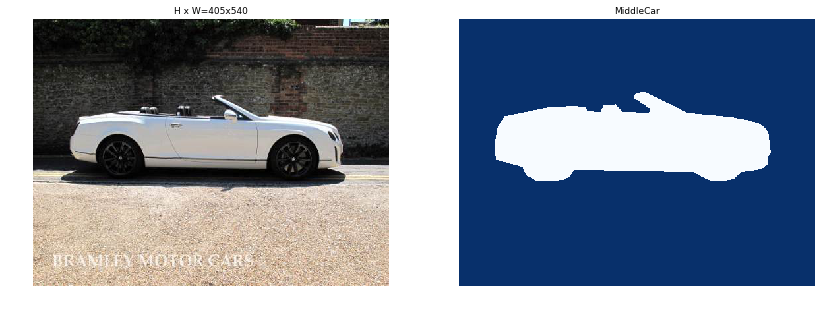

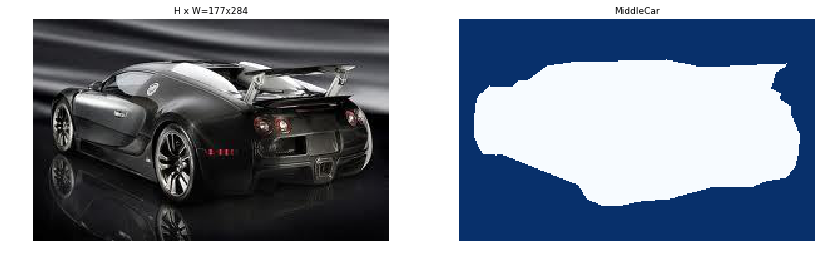

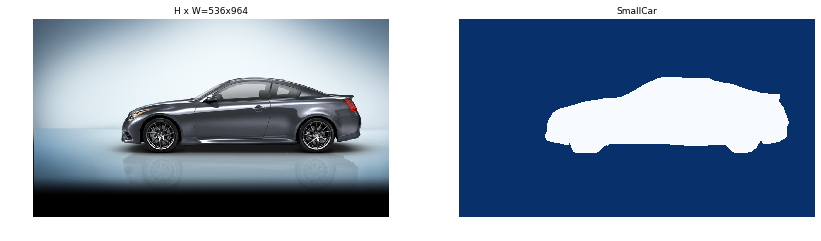

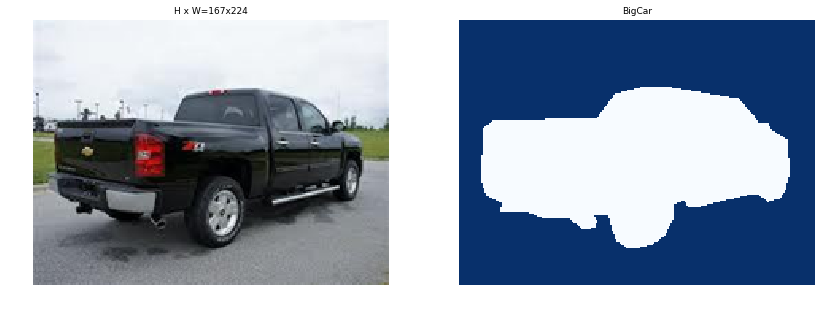

In [51]:
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, 1)

훈련 모델 생성

In [0]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

모델 학습.
( time abort나서 model.py에서 train 함수. multiprocess = False, worker = 1로 설정)

In [0]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=10, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/Capstone2/Mask_RCNN-master/logs/car_size20190610T0210/mask_rcnn_car_size_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (Tim

테스트를 위한 설정.
DETECTION_MIN_CONFIDENCE에 따라 최소 물체 판정도 설정

In [0]:
class InferenceConfig(CarSizeConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    #DETECTION_MIN_CONFIDENCE = 0.75
    DETECTION_MIN_CONFIDENCE = 0.65
    

inference_config = InferenceConfig()

In [0]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

학습한 weight load

In [59]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()
 
# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
model.load_weights(model_path, by_name=True)

Re-starting from epoch 10


BigCar Test

Processing 1 images
image                    shape: (225, 300, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


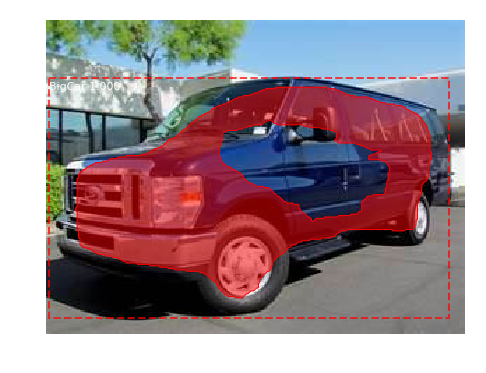

Processing 1 images
image                    shape: (426, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  640.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


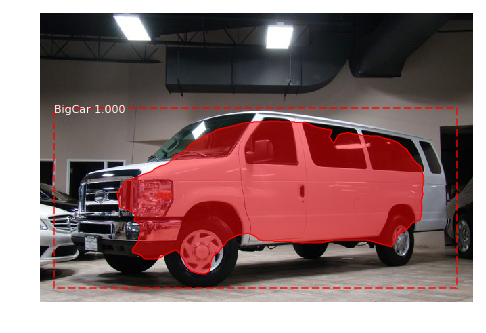

Processing 1 images
image                    shape: (194, 259, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


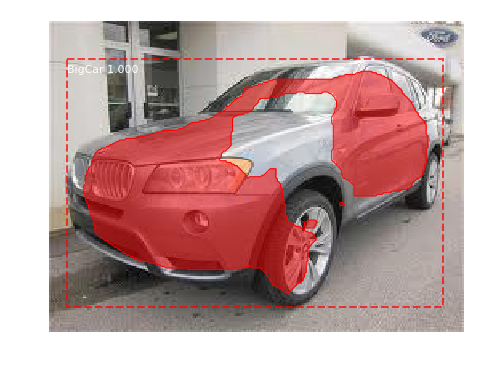

Processing 1 images
image                    shape: (194, 259, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


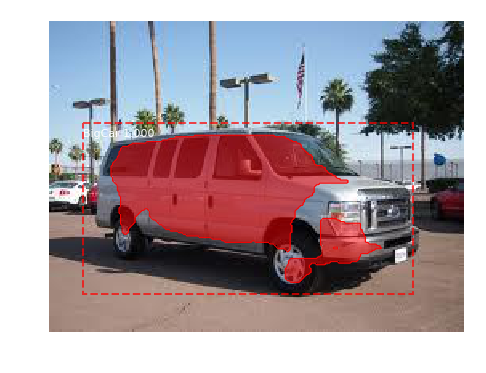

Processing 1 images
image                    shape: (385, 550, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  550.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


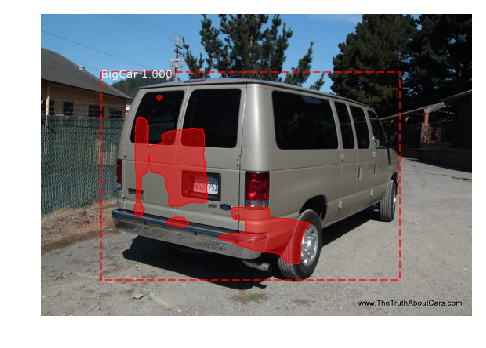

Processing 1 images
image                    shape: (337, 450, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


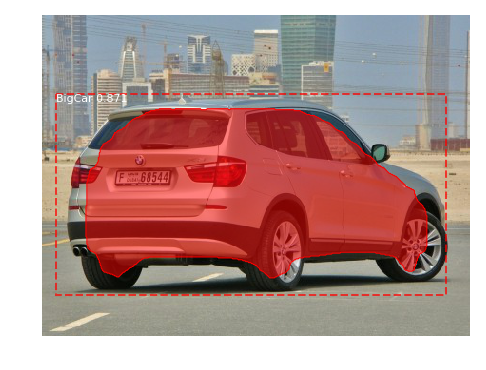

Processing 1 images
image                    shape: (400, 600, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  600.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


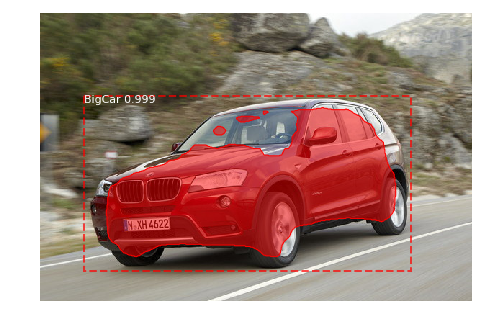

Processing 1 images
image                    shape: (199, 300, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  137.20000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


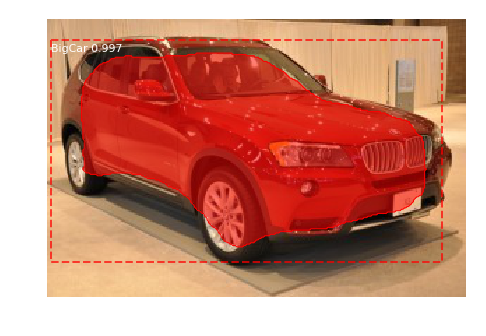

In [55]:
import skimage
real_test_dir = '/content/drive/Capstone2/datasets/Car_Size/test_category/BigCar'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(8,8))

Middle Car Test

Processing 1 images
image                    shape: (302, 720, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  720.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


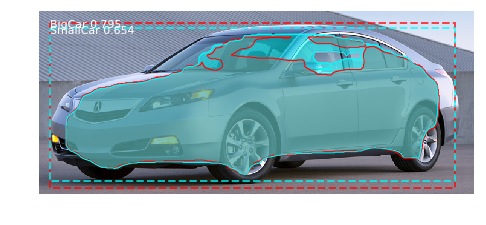

Processing 1 images
image                    shape: (424, 588, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  588.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


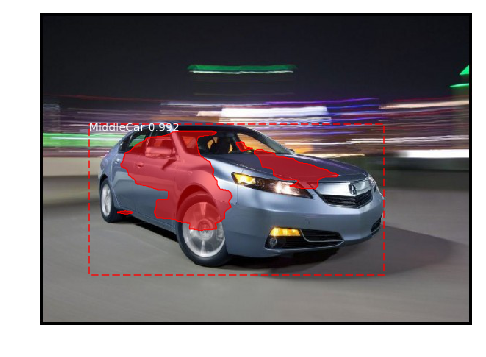

Processing 1 images
image                    shape: (182, 248, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


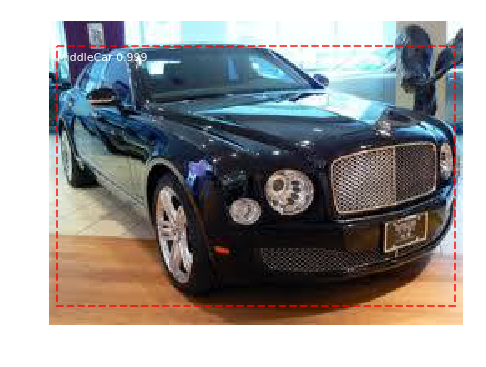

Processing 1 images
image                    shape: (225, 300, 3)         min:    0.00000  max:  248.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  140.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


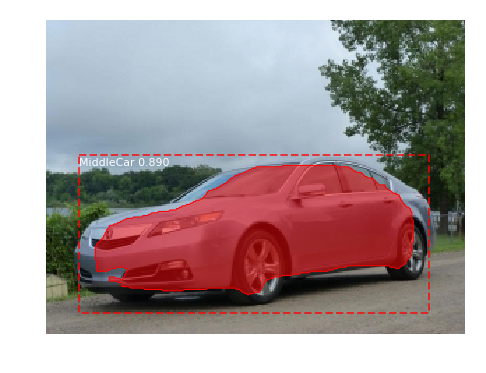

Processing 1 images
image                    shape: (850, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


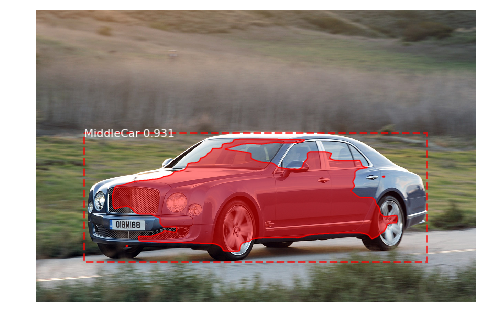

Processing 1 images
image                    shape: (318, 520, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  520.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


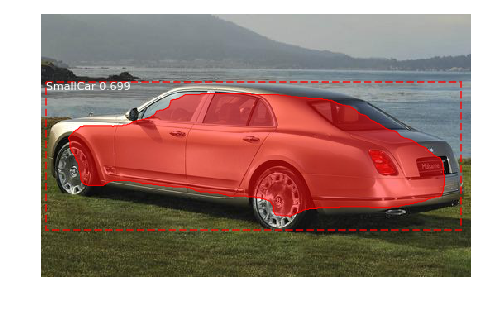

Processing 1 images
image                    shape: (442, 590, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  590.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


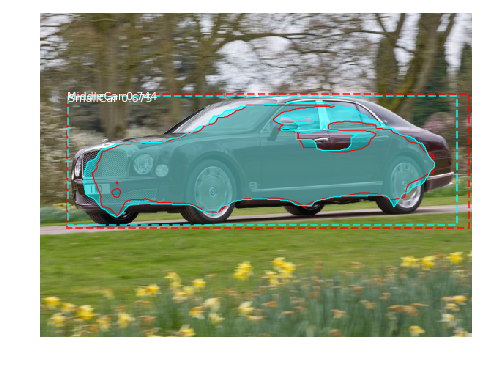

Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  640.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


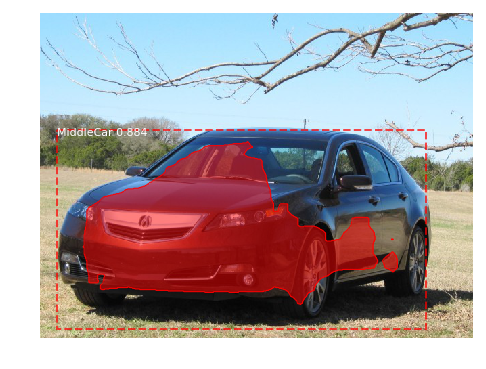

In [56]:
real_test_dir = '/content/drive/Capstone2/datasets/Car_Size/test_category/MiddleCar'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(8,8))

Small Car Test

In [57]:
real_test_dir = '/content/drive/Capstone2/datasets/Car_Size/test_category/SmallCar'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(8,8))

Output hidden; open in https://colab.research.google.com to view.

섞은 데이터 Test

In [58]:
import skimage
real_test_dir = '/content/drive/Capstone2/datasets/Car_Size/real_test'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)d
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(8,8))

Output hidden; open in https://colab.research.google.com to view.

학습한 모델의 weight 수치

In [0]:
visualize.display_weight_stats(model)